# **Modélisation statistique**
Nous allons mener des régressions linéaires de la production électrique éolienne (données API RTE) sur les données météorologiques de vents (données API ...)

Dans un premier temps, nous allons créer un data frame qui contiendra la moyenne nationale de la production électrique éolienne ainsi que la moyenne des vents nationaux, heure par heure pour l'année 2021.
Ensuite, nous affinerons l'analyse en faisant des régressions par région/année.

### **1) Récupération des données**

Dans un premier temps, nous cherchons à mettre les dates des données météorologique et des données RTE dans le même format. Le format cherché est, par exemple pour le 5 mai 2020 à 12h:

**2020-05-05:12:00**

#### **a) Données météorologiques**

In [1]:
import pandas as pd
import sys
import csv

csv.field_size_limit(sys.maxsize)

131072

In [2]:
donnees_vent = pd.read_csv('donnees_vent.csv', sep=",", names=['Index', 'Time', 'Windspeed'], engine='python', error_bad_lines=False)

donnees_vent_prediction = pd.read_csv('donnees_vent_prediction.csv', sep=",", names=['Index', 'Time', 'Windspeed'], engine='python', error_bad_lines=False)

/tmp/ipykernel_1315/83721686.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  donnees_vent = pd.read_csv('donnees_vent.csv', sep=",", names=['Index', 'Time', 'Windspeed'], engine='python', error_bad_lines=False)
Skipping line 206: unexpected end of data
/tmp/ipykernel_1315/83721686.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  donnees_vent_prediction = pd.read_csv('donnees_vent_prediction.csv', sep=",", names=['Index', 'Time', 'Windspeed'], engine='python', error_bad_lines=False)


In [3]:
donnees_vent

,Index,Time,Windspeed
0,0,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[1.43, 1.25, 1.7, 2.02, 2.08, 2.42, 2.64, 2.86..."
1,1,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
2,2,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
3,3,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
4,12,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[1.66, 1.88, 1.97, 2.25, 1.43, 1.51, 1.43, 1.3..."
...,...,...,...
200,260,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[0.94, 0.61, 1.03, 1.28, 1.84, 1.87, 1.73, 1.6..."
201,261,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[1.0, 1.12, 1.6, 1.96, 1.75, 1.68, 2.11, 2.8, ..."
202,262,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[1.0, 1.12, 1.6, 1.96, 1.75, 1.68, 2.11, 2.8, ..."
203,263,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[1.0, 1.12, 1.6, 1.96, 1.75, 1.68, 2.11, 2.8, ..."


In [4]:
donnees_vent_prediction.head()

,Index,Time,Windspeed
0,0,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[4.21, 3.23, 3.99, 2.79, 3.6, 3.42, 1.0, 2.24,..."
1,1,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[3.0, 2.45, 2.09, 2.1, 1.92, 1.62, 1.8, 1.81, ..."
2,2,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[3.0, 2.45, 2.09, 2.1, 1.92, 1.62, 1.8, 1.81, ..."
3,3,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[3.31, 2.84, 2.38, 2.33, 2.15, 1.93, 2.2, 2.24..."
4,4,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[4.74, 4.96, 4.8, 4.7, 4.39, 3.89, 2.91, 2.2, ..."


Le format des données est le suivant:

-L'index représente le numéro des éoliennes, numérotées de 0 à XXXX.

-La variable "Time" contient la liste de toutes les dates auxquelles on observe la vitesse du vent à la position de l'éolienne.

-La variable "Windspeed" contient la liste de la vitesse des vents.

Dans un premier temps, on va chercher à "nettoyer" la variable "Time" afin de créer une liste de dates harmonisées.

On va ajouter une colonne représentant la longueur du rotor de l'éolienne à partir de la précédente base de donnée.

In [5]:
df = pd.read_csv("eolien.csv", sep=";")

In [6]:
donnees_vent = donnees_vent.merge(df['diametre_rotor'],how = 'left',left_on = 'Index',right_index = True)
donnees_vent_prediction = donnees_vent_prediction.merge(df['diametre_rotor'],how = 'left',left_on = 'Index',right_index = True)

In [7]:
caracteres_time = ["'","[","]","T", ","]
    
for string in caracteres_time:
    donnees_vent["Time"] = donnees_vent["Time"].apply(lambda x: x.replace(string, ''))
    donnees_vent_prediction["Time"] = donnees_vent["Time"].apply(lambda x: x.replace(string, ''))    

In [8]:
caracteres_vent = ["[", "]", ","]

for string in caracteres_vent:
    donnees_vent["Windspeed"] = donnees_vent["Windspeed"].apply(lambda x: x.replace(string, ''))
    donnees_vent_prediction["Windspeed"] = donnees_vent["Windspeed"].apply(lambda x: x.replace(string, ''))

Maintenant que les variables "Time" et "Windspeed" sont nettoyées, on va utiliser la fonction explode afin d'avoir une base de données "classique" pour pouvoir faire des régressions. Nous allons étendre les listes afin que chaque vent soit associé à une date précise.

Premièrement, on convertit nos données considérés comme "string" en liste.

In [9]:
donnees_vent["Time"] = donnees_vent["Time"].str.split(' ')
donnees_vent["Time"] = donnees_vent["Time"].tolist()

donnees_vent_prediction["Time"] = donnees_vent_prediction["Time"].str.split(' ')
donnees_vent_prediction["Time"] = donnees_vent_prediction["Time"].tolist()

In [10]:
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].str.split(' ')
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].tolist()

donnees_vent_prediction["Windspeed"] = donnees_vent_prediction["Windspeed"].str.split(' ')
donnees_vent_prediction["Windspeed"] = donnees_vent_prediction["Windspeed"].tolist()

In [11]:
donnees_vent = donnees_vent.set_index(['Index']).apply(pd.Series.explode).reset_index()

donnees_vent_prediction = donnees_vent_prediction.set_index(['Index']).apply(pd.Series.explode).reset_index()

In [12]:
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].astype(float)
donnees_vent["Index"] = donnees_vent["Index"].astype(str)

donnees_vent_prediction["Windspeed"] = donnees_vent_prediction["Windspeed"].astype(float)
donnees_vent_prediction["Index"] = donnees_vent_prediction["Index"].astype(str)

In [13]:
donnees_vent["Windspeed_cubed"] = donnees_vent["Windspeed"].pow(3)
donnees_vent_prediction["Windspeed_cubed"] = donnees_vent_prediction["Windspeed"].pow(3)

In [14]:
donnees_vent["rotor_carre"] = donnees_vent["diametre_rotor"].pow(2)

donnees_vent_prediction["rotor_carre"] = donnees_vent_prediction["diametre_rotor"].pow(2)

In [15]:
donnees_vent

,Index,Time,Windspeed,diametre_rotor,Windspeed_cubed,rotor_carre
0,0,2021-01-0100:00,1.43,53.0,2.924207,2809.0
1,0,2021-01-0101:00,1.25,53.0,1.953125,2809.0
2,0,2021-01-0102:00,1.70,53.0,4.913000,2809.0
3,0,2021-01-0103:00,2.02,53.0,8.242408,2809.0
4,0,2021-01-0104:00,2.08,53.0,8.998912,2809.0
...,...,...,...,...,...,...
1698979,264,2021-12-3119:00,2.12,80.0,9.528128,6400.0
1698980,264,2021-12-3120:00,2.12,80.0,9.528128,6400.0
1698981,264,2021-12-3121:00,1.97,80.0,7.645373,6400.0
1698982,264,2021-12-3122:00,1.21,80.0,1.771561,6400.0


In [16]:
def weighted_sum(group):
    d = group['rotor_carre']
    v = group['Windspeed_cubed']
    return (d*v).sum()

vent_somme = donnees_vent.groupby(['Time']).apply(weighted_sum)
vent_somme_prediction = donnees_vent_prediction.groupby(['Time']).apply(weighted_sum)

In [17]:
vent_somme = vent_somme.to_frame()
vent_somme_prediction = vent_somme_prediction.to_frame()

#### **b) Données RTE**
On importe les données RTE auparavant obtenu grâce à une API.

**Pour l'instant:** données test de Janvier à Février 2020

In [18]:
data_RTE = pd.read_csv('RTE_test.xls')

In [19]:
data_RTE

,Unnamed: 0,start_date,end_date,updated_date,value
0,0,2021-01-01 00:00:00+01:00,2021-01-01 01:00:00+01:00,2021-01-01T00:40:58+01:00,1082
1,1,2021-01-01 01:00:00+01:00,2021-01-01 02:00:00+01:00,2021-01-01T01:40:58+01:00,1075
2,2,2021-01-01 02:00:00+01:00,2021-01-01 03:00:00+01:00,2021-01-01T02:40:55+01:00,1086
3,3,2021-01-01 03:00:00+01:00,2021-01-01 04:00:00+01:00,2021-01-01T03:40:57+01:00,1149
4,4,2021-01-01 04:00:00+01:00,2021-01-01 05:00:00+01:00,2021-01-01T04:40:54+01:00,1170
...,...,...,...,...,...
3618,3618,2021-05-31 19:00:00+02:00,2021-05-31 20:00:00+02:00,2021-05-31T18:38:14+02:00,2304
3619,3619,2021-05-31 20:00:00+02:00,2021-05-31 21:00:00+02:00,2021-05-31T19:33:04+02:00,2316
3620,3620,2021-05-31 21:00:00+02:00,2021-05-31 22:00:00+02:00,2021-05-31T20:34:02+02:00,2845
3621,3621,2021-05-31 22:00:00+02:00,2021-05-31 23:00:00+02:00,2021-05-31T21:33:59+02:00,3840


On renomme les trois colonnes nécessaires et on enlève les colonnes inutiles

In [20]:
columns_to_drop = ['end_date', 'updated_date']
data_RTE = data_RTE.drop(columns_to_drop, axis=1)

columns_to_rename = {'Unnamed: 0': 'Index', 'start_date': 'Time', 'value': 'Electricity'}
data_RTE = data_RTE.rename(columns=columns_to_rename)

On enlève les éléments de la date inutile afin d'harmoniser

In [21]:
caracteres = ["+01:00"," ","+02:00"]
    
for string in caracteres:
    data_RTE["Time"] = data_RTE["Time"].apply(lambda x: x.replace(string, ''))

data_RTE["Time"] = data_RTE["Time"].str[:-3]

In [22]:
data_RTE

,Index,Time,Electricity
0,0,2021-01-0100:00,1082
1,1,2021-01-0101:00,1075
2,2,2021-01-0102:00,1086
3,3,2021-01-0103:00,1149
4,4,2021-01-0104:00,1170
...,...,...,...
3618,3618,2021-05-3119:00,2304
3619,3619,2021-05-3120:00,2316
3620,3620,2021-05-3121:00,2845
3621,3621,2021-05-3122:00,3840


Les dates sont bien au format harmonisé voulu.

#### **c) Merge des deux database**

In [23]:
vent_somme.columns = ['Windspeed_cubed']
vent_somme_prediction.columns = ['Windspeed_cubed']

In [24]:
vent_somme

,Windspeed_cubed
Time,
2021-01-0100:00,7.021859e+06
2021-01-0101:00,7.445100e+06
2021-01-0102:00,8.663478e+06
2021-01-0103:00,8.906593e+06
2021-01-0104:00,9.552695e+06
...,...
2021-12-3119:00,8.098053e+07
2021-12-3120:00,1.008941e+08
2021-12-3121:00,9.213382e+07


In [25]:
data = data_RTE.merge(vent_somme, on='Time')

In [26]:
data['Electricity'] = (1e6)*data['Electricity']

### **2) Les régressions linéaires**

Dans un premier temps, on va regresser l'électricité produite sur le vent au cube afin de retrouver le coefficient $1/2 \rho S$ où $S = \pi/4 d^2$ est la surface de brassage de l'éolienne avec $d$ le diamètre du rotor. 

Ensuite on régressera le log de l'électricité produite sur le log du vent afin de retrouver le cube.

#### **a) Spécification de base**

In [28]:
import statsmodels.formula.api as smf

def regression_results_no_cte(x, y, z):
    model = smf.ols(y+"~"+z+"-1", data=x).fit(cov_type='HC1')
    predictions = model.predict(x)
    print(model.summary())
    
def regression_results(x, y, z):
    model = smf.ols(y+"~"+z, data=x).fit(cov_type='HC1')
    predictions = model.predict(x)
    print(model.summary())
    
regression_results_no_cte(data, "Electricity", "Windspeed_cubed")  

                                 OLS Regression Results                                
Dep. Variable:            Electricity   R-squared (uncentered):                   0.776
Model:                            OLS   Adj. R-squared (uncentered):              0.776
Method:                 Least Squares   F-statistic:                              2202.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                        0.00
Time:                        08:50:39   Log-Likelihood:                         -83881.
No. Observations:                3623   AIC:                                  1.678e+05
Df Residuals:                    3622   BIC:                                  1.678e+05
Df Model:                           1                                                  
Covariance Type:                  HC1                                                  
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

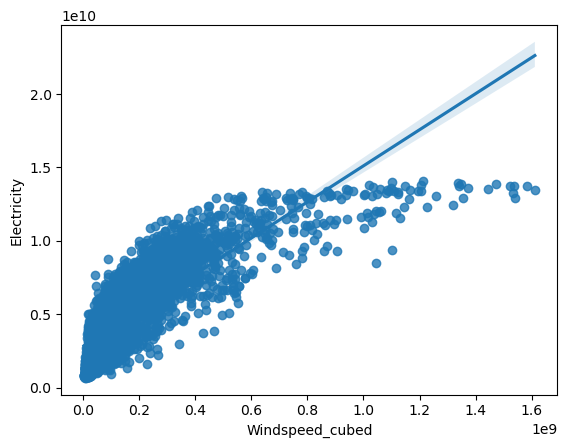

In [29]:
import seaborn as sns

def plot_linear_regression(x, y, z):
    plot = sns.regplot(x=z, y=y, data=x)
    return plot

plot = plot_linear_regression(data, "Electricity", "Windspeed_cubed")

#### **Deuxième régression: avec log**


In [30]:
import numpy as np
data['Electricity_log'] = np.log(data['Electricity'])
data['Windspeed_log'] = np.log(data['Windspeed_cubed'])/3

In [31]:
regression_results(data, "Electricity_log", "Windspeed_log")  

                            OLS Regression Results                            
Dep. Variable:        Electricity_log   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                 1.291e+04
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        08:50:40   Log-Likelihood:                -1314.0
No. Observations:                3623   AIC:                             2632.
Df Residuals:                    3621   BIC:                             2644.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.1443      0.090    135.096

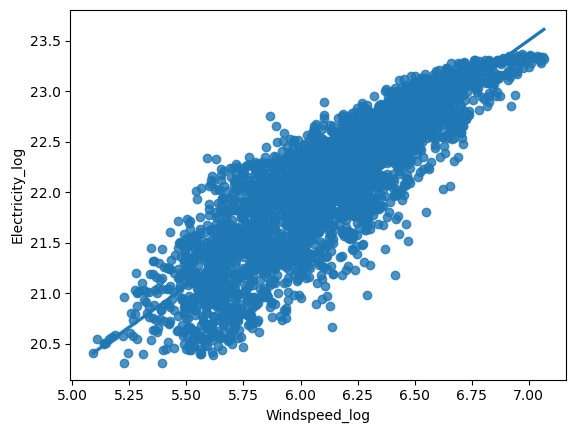

In [32]:
plot = plot_linear_regression(data, "Electricity_log", "Windspeed_log")

#### **c) Troisième spécification : régression avec la cassure**

In [33]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

In [34]:
model_cassure = DecisionTreeRegressor(min_samples_leaf=10, max_depth=1)

In [35]:
X = data['Windspeed_cubed'].to_numpy()
X = X.reshape(-1, 1)

y = data['Electricity'].to_numpy()

In [36]:
model_cassure.fit(X, y)
y_pred = model_cassure.predict(X)

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


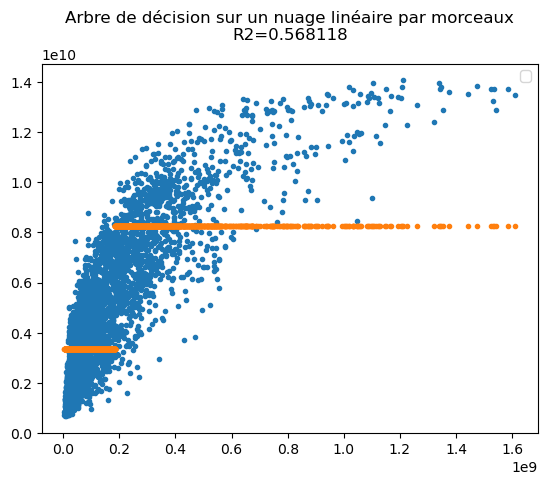

In [38]:
fig, ax = plt.subplots(1, 1)
ax.plot(X, y, ".")
ax.plot(X, y_pred, ".")
ax.legend()
r2 = r2_score(y, y_pred)
ax.set_title("Arbre de décision sur un nuage linéaire par morceaux\nR2=%f" % r2);

In [39]:
cassure = list(sorted(set(model_cassure.tree_.threshold)))
cassure += [(cassure[i] + cassure[i-1])/2 for i in range(1,len(cassure)-1)]
cassure = list(sorted(cassure))
cassure

[-2.0, 185405296.0]

In [40]:
data_sup = data[data['Windspeed_cubed']>cassure[1]]
data_inf = data[data['Windspeed_cubed']<cassure[1]]

In [41]:
regression_results_no_cte(data_inf, "Electricity", "Windspeed_cubed")  

                                 OLS Regression Results                                
Dep. Variable:            Electricity   R-squared (uncentered):                   0.842
Model:                            OLS   Adj. R-squared (uncentered):              0.842
Method:                 Least Squares   F-statistic:                              9549.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                        0.00
Time:                        08:50:42   Log-Likelihood:                         -55289.
No. Observations:                2452   AIC:                                  1.106e+05
Df Residuals:                    2451   BIC:                                  1.106e+05
Df Model:                           1                                                  
Covariance Type:                  HC1                                                  
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

<AxesSubplot: xlabel='Windspeed_cubed', ylabel='Electricity'>

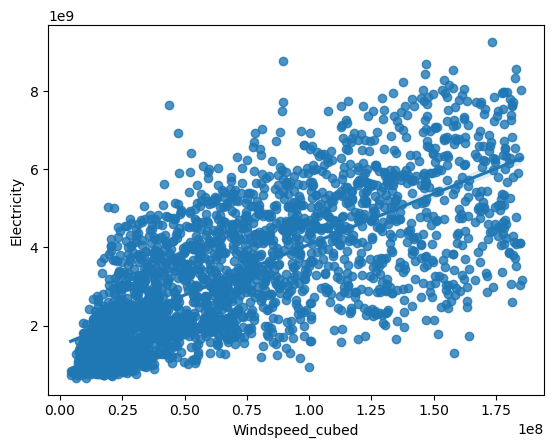

In [42]:
plot_linear_regression(data_inf, "Electricity", "Windspeed_cubed")

In [43]:
regression_results(data_sup, "Electricity", "Windspeed_cubed")  

                            OLS Regression Results                            
Dep. Variable:            Electricity   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     957.7
Date:                Fri, 16 Dec 2022   Prob (F-statistic):          4.30e-154
Time:                        08:50:42   Log-Likelihood:                -26578.
No. Observations:                1171   AIC:                         5.316e+04
Df Residuals:                    1169   BIC:                         5.317e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5.481e+09   1.03e+08     

<AxesSubplot: xlabel='Windspeed_cubed', ylabel='Electricity'>

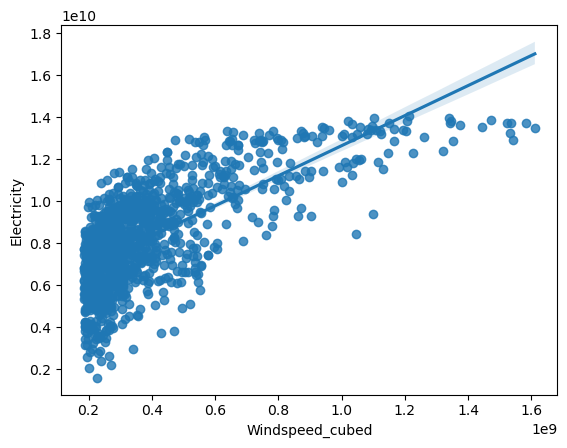

In [44]:
plot_linear_regression(data_sup, "Electricity", "Windspeed_cubed")

In [45]:
y_inf = 40.1353*data_inf['Windspeed_cubed']
y_sup = 5.481e09+7.1605*data_sup['Windspeed_cubed']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Régression linéaire coudée')

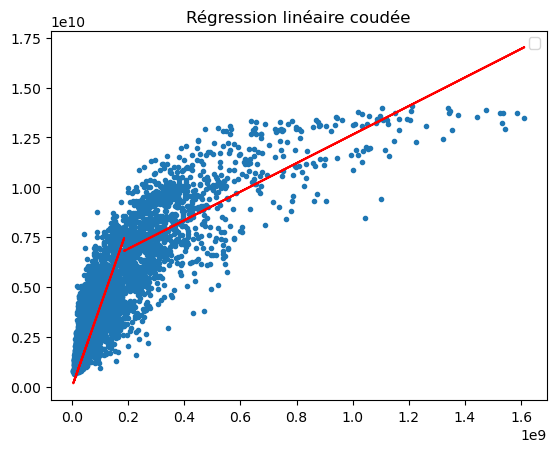

In [46]:
fig, ax = plt.subplots(1, 1)
ax.plot(data['Windspeed_cubed'],data['Electricity'], ".")
ax.plot(data_inf['Windspeed_cubed'], y_inf, color='red')
ax.plot(data_sup['Windspeed_cubed'], y_sup, color='red')
ax.legend()
ax.set_title('Régression linéaire coudée')

#### **e) Cinquième spécification : masse volumique de l'air**

In [47]:
rho_air = 1.2

def calcul_energie(diametre_rotor,vitesse_vent):
    return 16/27/2 * rho_air * np.pi/4 * diametre_rotor**2 * np.power(vitesse_vent,3)

In [48]:
donnees_vent['Energie'] = calcul_energie(donnees_vent['diametre_rotor'],donnees_vent['Windspeed'])

In [49]:
donnees_energie = donnees_vent

,Index,Time,Windspeed,diametre_rotor,Windspeed_cubed,rotor_carre,Energie
0,0,2021-01-0100:00,1.43,53.0,2.924207,2809.0,2293.808733
1,0,2021-01-0101:00,1.25,53.0,1.953125,2809.0,1532.071834
2,0,2021-01-0102:00,1.70,53.0,4.913000,2809.0,3853.859287
3,0,2021-01-0103:00,2.02,53.0,8.242408,2809.0,6465.516104
4,0,2021-01-0104:00,2.08,53.0,8.998912,2809.0,7058.933561
...,...,...,...,...,...,...,...
1698979,264,2021-12-3119:00,2.12,80.0,9.528128,6400.0,17028.833808
1698980,264,2021-12-3120:00,2.12,80.0,9.528128,6400.0,17028.833808
1698981,264,2021-12-3121:00,1.97,80.0,7.645373,6400.0,13663.941775
1698982,264,2021-12-3122:00,1.21,80.0,1.771561,6400.0,3166.164209


In [50]:
columns_to_drop = ['Windspeed', 'diametre_rotor', 'rotor_carre', 'Windspeed_cubed']
donnees_energie = donnees_energie.drop(columns_to_drop, axis=1)

In [56]:
energie_somme = donnees_energie.groupby(['Time']).sum()

/tmp/ipykernel_1315/4232588806.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  energie_somme = donnees_energie.groupby(['Time']).sum()


In [58]:
data_energie = data_RTE.merge(energie_somme, on='Time')

In [59]:
data_energie['Electricity'] = (1e6)*data_energie['Electricity']

In [60]:
regression_results(data_energie, "Electricity", "Energie")  

                            OLS Regression Results                            
Dep. Variable:            Electricity   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     1656.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):          1.53e-298
Time:                        08:57:17   Log-Likelihood:                -82234.
No. Observations:                3623   AIC:                         1.645e+05
Df Residuals:                    3621   BIC:                         1.645e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.791e+09   4.97e+07     56.117      0.0

<AxesSubplot: xlabel='Energie', ylabel='Electricity'>

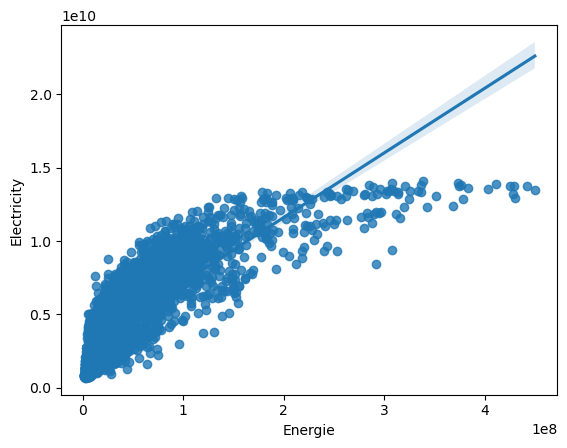

In [61]:
plot_linear_regression(data_energie, "Electricity", "Energie")

#### **f) Prédiction avec données vents prévus**